**[MAC5742] Introdução à Computação Paralela e Distribuída**

Michelly Rodrigues da Silva
11270607

# Exercício-Programa 1: Conjunto de Mandelbrot

## Introdução

O objetivo deste relatório é avaliar o impacto da paralelização do cálculo do conjunto de Mandelbrot usando a biblioteca `pthreads` e diretivas de compilação pelo `OpenMP` para diferentes tamanhos de entrada e número de `threads`.

O primeiro experimento analisa o impacto das operações de I/O e alocação de memória em comparação com o mesmo código sem essas porções não paralelizáveis.

Parâmetros:  

 - Número de medições: 20 
 - Número de *threads*: 16 
 - Tamanho da entrada: 16×2\textsuperscript{0} ... 16×2\textsuperscript{10}


Já o segundo experimento avalia o impacto do número de *threads* na execução do código paralelizado. Como são testes de desempenhos, operações de I/O e alocação de memória **não** foram feitas.

Parâmetros:  

 - Número de medições: 20 
 - Número de threads: 2\textsuperscript{0} ... 2\textsuperscript{5} 
 - Tamanho da entrada: 16×2\textsuperscript{0} ... 16×2\textsuperscript{10} 

Principais especificações da máquina:  

| Componente           | Especificação                                                                                                            |
|----------------------|:--------------------------------------------------------------------------------------------------------------------------|
| Processador (CPU)    | AMD Ryzen 7 4800H (Série 4000) / 8 núcleos / 16 threads / 8 MB de cache / de 2.90 GHz até 4.20 GHz                    |
| Placa de vídeo (GPU) | GPU dedicada NVIDIA GeForce GTX 1650 / 4 GB GDDR6                                                                       |
| Memória RAM          | 16 GB DDR4 3200 MHz                                                                                                   |
| Sistema Operacional  | Linux ubuntu 6.8.0-45-generic #45-Ubuntu SMP PREEMPT_DYNAMIC Fri Aug 30 12:02:04 UTC 2024 x86_64 x86_64 x86_64 GNU/Linux |

O código utilizado para gerar o dataset das análises se encontra no arquivo `generate_csv.ipynb`.

## Desenvolvimento
### 1º Experimento - Impacto das operações de I/O e alocação de memória

In [1]:
import pandas as pd

raw_data = pd.read_csv('final_results.csv')
raw_data.sample(5)

,name,region,size,task_clock,CPUs_utilized,context_switches,cpu_migrations,page_faults,cycles,stalled_cycles_frontend,instructions,branches,branch_misses,time_elapsed,IO,num_threads
7762,mandelbrot_pth,full,64,2.59,1.229,6,0,94,954.901,200.751,560.906,810.766,73.302,0.002104,False,4
1615,mandelbrot_pth,seahorse,512,272.02,0.996,3,0,80,493.116,620.247,84.762,57.376,373.024,0.273170,False,1
10621,mandelbrot_omp,elephant,32,4.67,2.223,0,0,87,974.088,918.078,410.536,217.694,61.908,0.002102,False,8
16169,mandelbrot_omp,full,8192,619.43,4.516,321,16,104,616.121,92.359,286.549,118.400,778.006,2.130300,False,16
13675,mandelbrot_seq,triple_spiral,512,300.11,0.995,5,0,60,905.428,143.508,412.432,878.863,382.082,0.301580,False,16


In [2]:
raw_data.describe()

,size,task_clock,CPUs_utilized,context_switches,cpu_migrations,page_faults,cycles,stalled_cycles_frontend,instructions,branches,branch_misses,time_elapsed,num_threads
count,20280.000000,20280.000000,20280.000000,20280.000000,20280.000000,20280.000000,20280.000000,20280.000000,20280.000000,20280.000000,20280.000000,20280.000000,20280.000000
mean,1636.800000,218.467712,3.644376,74.176726,12.145266,101.382939,490.119688,497.137366,486.065899,517.383840,261.975206,3.401477,10.928994
std,2503.804083,283.860161,3.848348,162.912602,40.744309,84.505081,297.991861,291.229346,290.552948,274.000459,248.833973,11.231607,10.950169
min,16.000000,0.480000,0.481000,0.000000,0.000000,23.000000,2.917000,4.695000,1.951000,2.230000,4.902000,0.001093,1.000000
25%,64.000000,7.470000,0.999000,1.000000,0.000000,74.000000,233.060000,230.485000,243.596000,299.764000,65.959000,0.003801,2.000000
50%,384.000000,76.250000,1.843000,8.000000,0.000000,82.000000,461.323000,486.525000,455.726000,527.462000,152.701000,0.031490,8.000000
75%,2048.000000,310.250000,4.623000,55.000000,7.000000,104.000000,745.839000,748.523000,746.834000,742.216000,385.661000,1.036170,16.000000
max,8192.000000,999.210000,14.441000,993.000000,455.000000,947.000000,997.844000,997.838000,992.708000,996.612000,997.915000,79.417000,32.000000


In [3]:
raw_data_with_io = raw_data[raw_data['IO'] == True]
raw_data_with_io = raw_data_with_io[raw_data_with_io['num_threads'] == 16]

In [4]:
df_seq = raw_data_with_io[raw_data_with_io['name'] == 'mandelbrot_seq']
df_pth = raw_data_with_io[raw_data_with_io['name'] == 'mandelbrot_pth']
df_omp = raw_data_with_io[raw_data_with_io['name'] == 'mandelbrot_omp']

In [5]:
raw_data_without_io = raw_data[raw_data['IO'] == False]
raw_data_without_io = raw_data_without_io[raw_data_without_io['num_threads'] == 16]

In [6]:
df_seq_without_io = raw_data_without_io[raw_data_without_io['name'] == 'mandelbrot_seq']
df_pth_without_io = raw_data_without_io[raw_data_without_io['name'] == 'mandelbrot_pth']
df_omp_without_io = raw_data_without_io[raw_data_without_io['name'] == 'mandelbrot_omp']

In [7]:
from utils.plots import plot_side_by_side

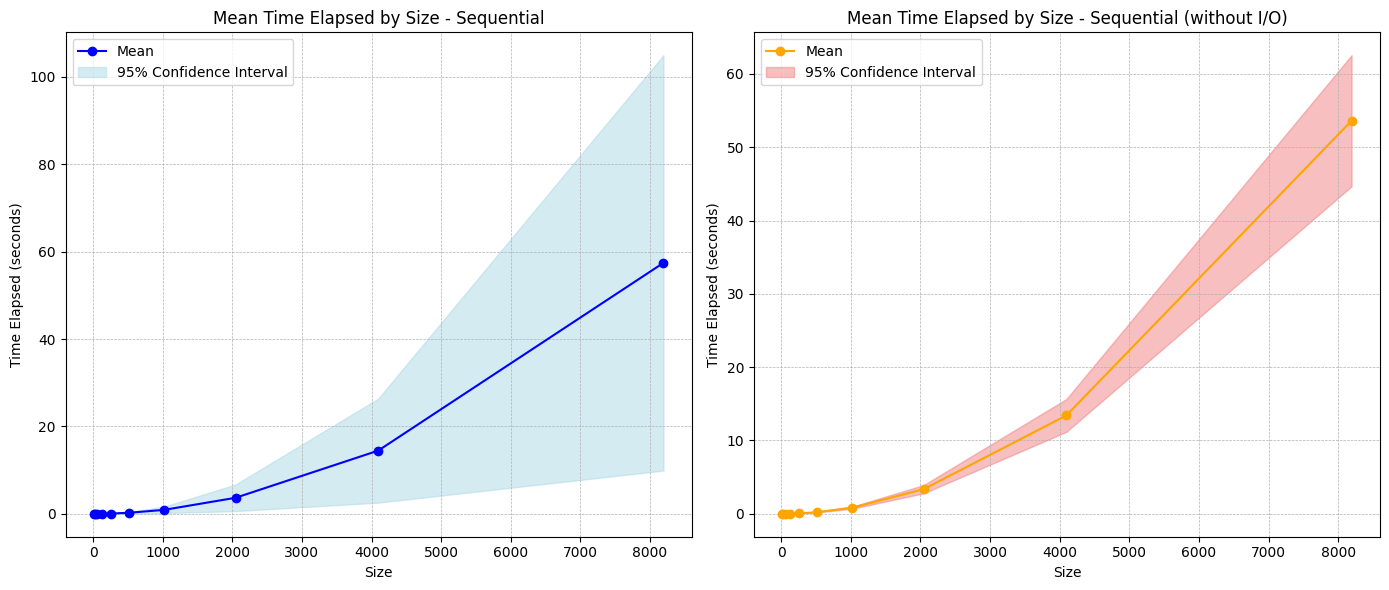

In [8]:
plot_side_by_side(df_seq, df_seq_without_io, title="Mean Time Elapsed by Size - Sequential")

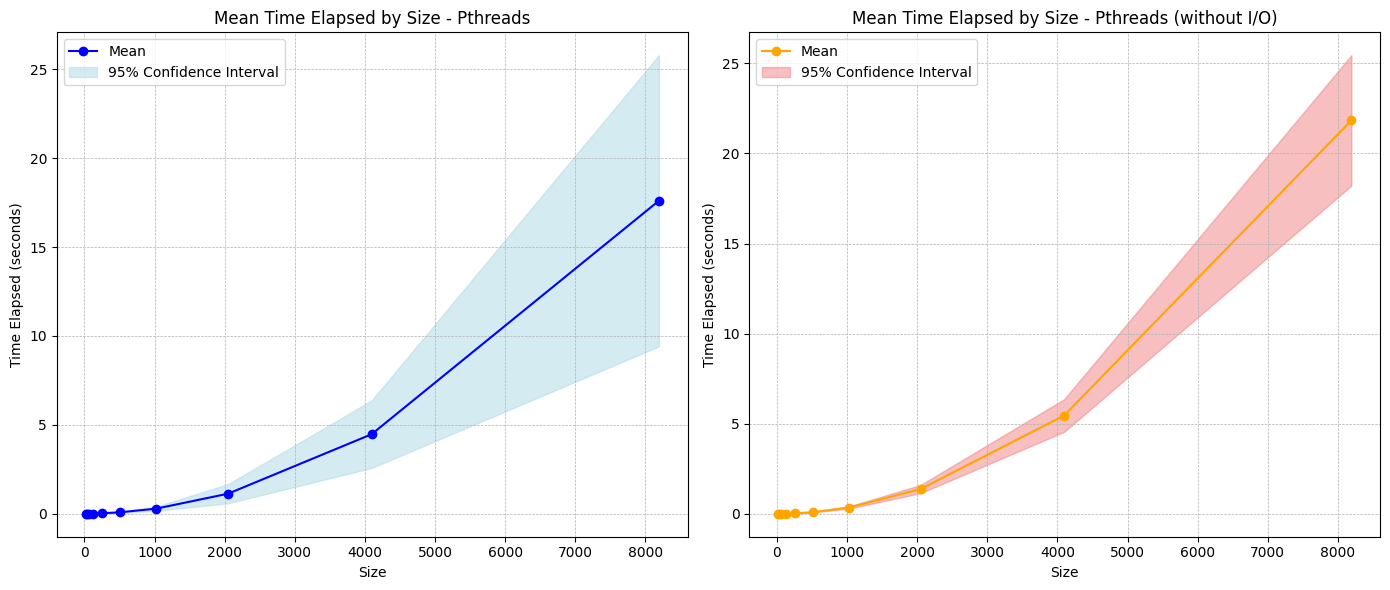

In [9]:
plot_side_by_side(df_pth, df_pth_without_io, title="Mean Time Elapsed by Size - Pthreads")

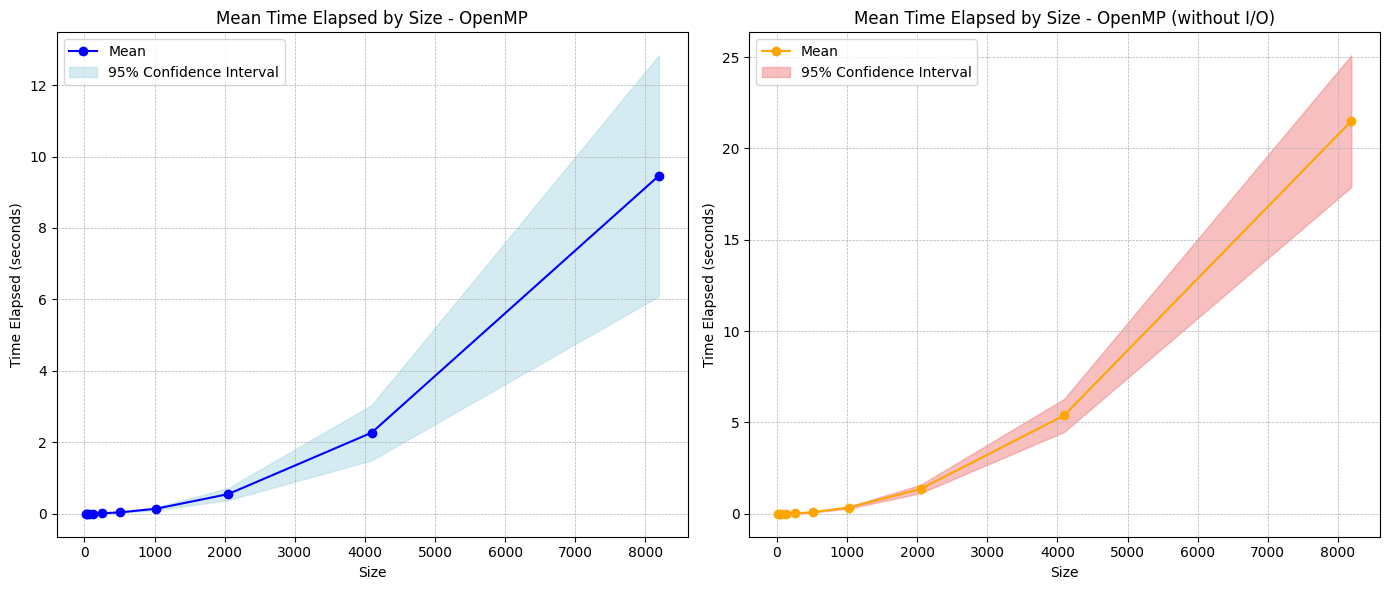

In [10]:
plot_side_by_side(df_omp, df_omp_without_io, title="Mean Time Elapsed by Size - OpenMP")

#### Execução sequencial - Tempo médio de execução por tamanho

In [11]:
from utils.plots import plot_mean_ci_by_region

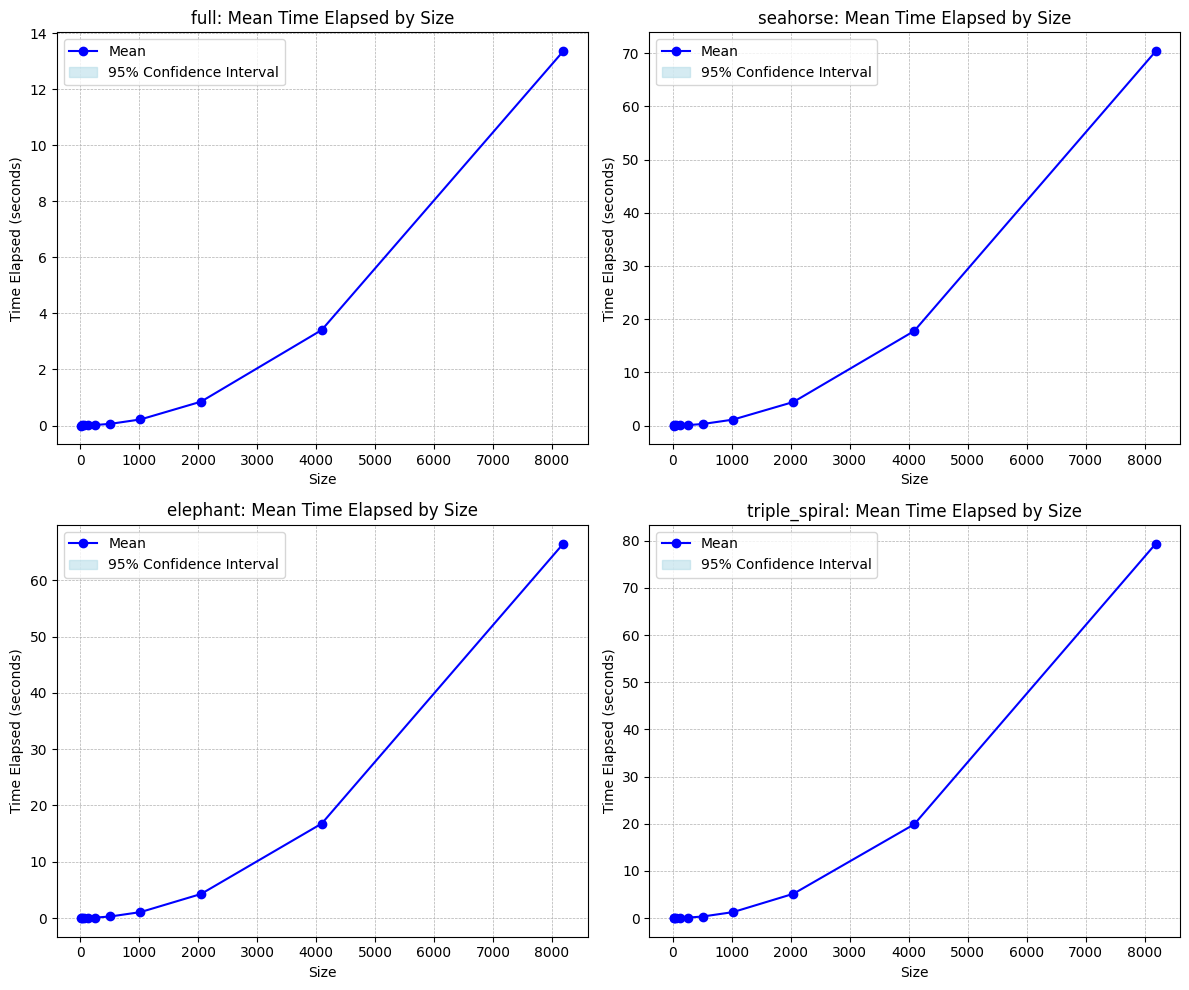

In [12]:
plot_mean_ci_by_region(df_seq)

#### Execução usando pthreads - Tempo médio de execução por tamanho

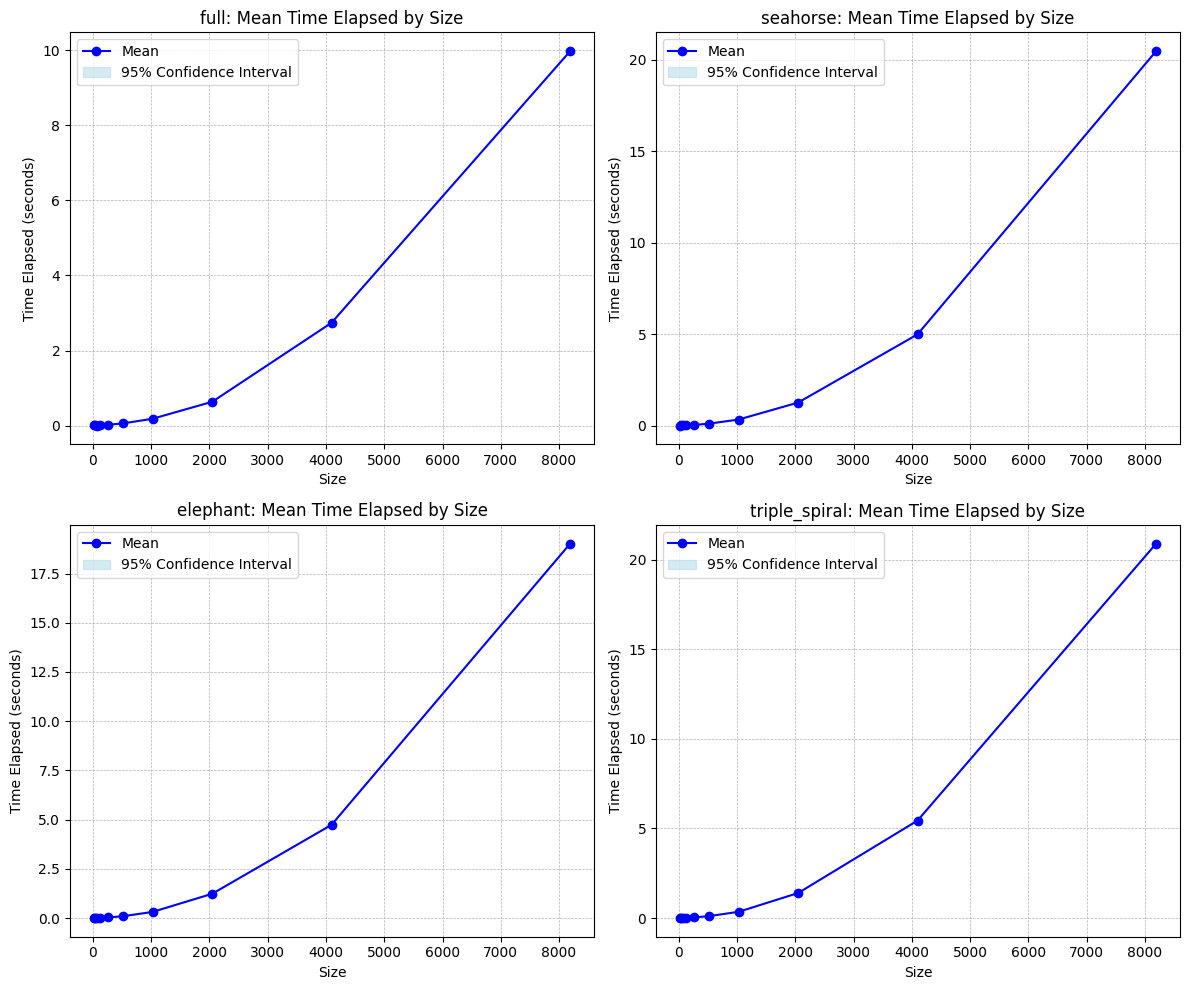

In [13]:
plot_mean_ci_by_region(df_pth)

#### Execução usando OpenMP - Tempo médio de execução por tamanho

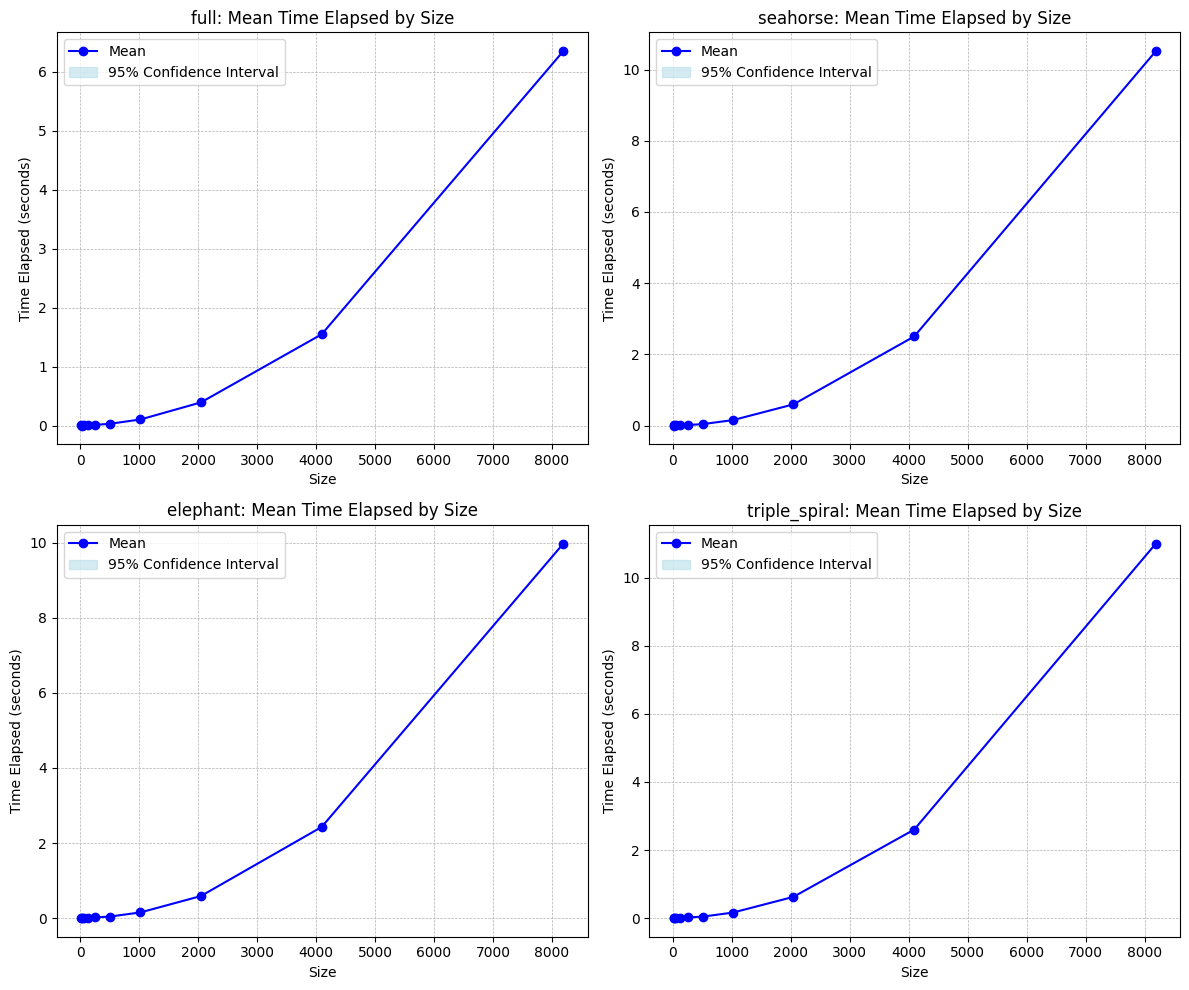

In [14]:
plot_mean_ci_by_region(df_omp)

In [15]:
df_seq[df_seq['region'] == 'triple_spiral'].describe()

,size,task_clock,CPUs_utilized,context_switches,cpu_migrations,page_faults,cycles,stalled_cycles_frontend,instructions,branches,branch_misses,time_elapsed,num_threads
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.0
mean,1636.800000,277.517000,0.928500,49.400000,3.700000,344.900000,407.253800,718.743800,504.518300,343.365800,447.988000,10.612787,16.0
std,2639.176168,354.681956,0.118544,104.597854,8.692909,308.429156,304.901141,232.070784,343.166949,241.511502,396.359235,24.953109,0.0
min,16.000000,1.520000,0.641000,0.000000,0.000000,24.000000,10.675000,372.985000,48.193000,11.434000,35.152000,0.002370,16.0
25%,80.000000,14.265000,0.946000,0.000000,0.000000,80.500000,200.925250,488.609750,202.300000,188.048500,61.305750,0.014955,16.0
50%,384.000000,163.590000,0.977000,2.500000,0.000000,263.500000,373.815500,846.978500,459.138500,266.031000,405.949000,0.202130,16.0
75%,1792.000000,307.737500,0.996750,36.500000,2.000000,574.250000,600.683500,897.693500,830.993500,498.299250,834.858000,4.164810,16.0
max,8192.000000,982.880000,0.998000,335.000000,28.000000,904.000000,911.860000,965.478000,968.170000,758.058000,982.503000,79.417000,16.0


Observando os gráficos acima e com uma simples análise descritiva de `time_elapsed` no conjunto de dados da execução sequencial com I/O conclue-se que o maior tempo de execução médio ocorre na geração das imagens do tipo `triple_spiral`. Outro comportamento observado é que a remoção dessas operações aumentou o tempo de execução médio do código paralelizado significativamente, levantando algumas hipóteses como:

  - Overhead de contexto: se muitas threads são criadas e executadas simultaneamente, o sistema operacional pode gastar mais tempo gerenciando o contexto das threads do que executando o código efetivamente;

  - Concorrência excessiva: em um cenário onde há muitas threads competindo por recursos limitados (como CPU, memória e I/O), isso pode levar a uma situação de contenção, onde as threads estão frequentemente esperando por recursos, resultando em um tempo de execução geral mais lento;

 - Deadlock: se as threads não gerenciam adequadamente o acesso a recursos compartilhados, pode ocorrer um interbloqueio, onde duas ou mais threads ficam presas, esperando umas pelas outras. Isso pode fazer com que o tempo total de execução aumente significativamente;

 - Falta de paralelismo eficiente: se a carga de trabalho não é adequada para múltiplas threads (por exemplo, se a maioria do tempo é gasta em operações sequenciais), o uso de threads pode introduzir mais complexidade e sobrecarga sem proporcionar ganhos de desempenho;

- Escalonamento ineficiente: o algoritmo de escalonamento do sistema operacional pode não ser capaz de gerenciar eficientemente uma grande quantidade de threads, resultando em um desempenho subótimo;

- Desvio de Cache: quando muitas threads estão acessando dados que não estão na cache do CPU, pode haver um aumento no tempo de acesso à memória, o que afeta negativamente o desempenho.

Tal comportamento é evidenciado pelo ganho do tempo médio de execução do código sequencial com a remoção das operações de I/O e alocação de memória.

### 2º Experimento - Impacto do número de threads

In [16]:
df = raw_data
df = df[df['IO'] == False]
df = df[df['name'] != 'mandelbrot_seq']
df = df.filter(['name', 'region', 'time_elapsed', 'size' ,'num_threads'])
df.sample(5)

,name,region,time_elapsed,size,num_threads
9312,mandelbrot_omp,triple_spiral,0.004557,64,4
10561,mandelbrot_pth,full,0.001634,32,8
771,mandelbrot_pth,seahorse,0.001763,32,1
2362,mandelbrot_omp,full,0.002333,64,1
18506,mandelbrot_pth,elephant,0.163530,1024,32


In [17]:
from utils.plots import plot_mean_ci_by_region_num_threads

#### Tempo médio de execução por número de threads - Pthreads

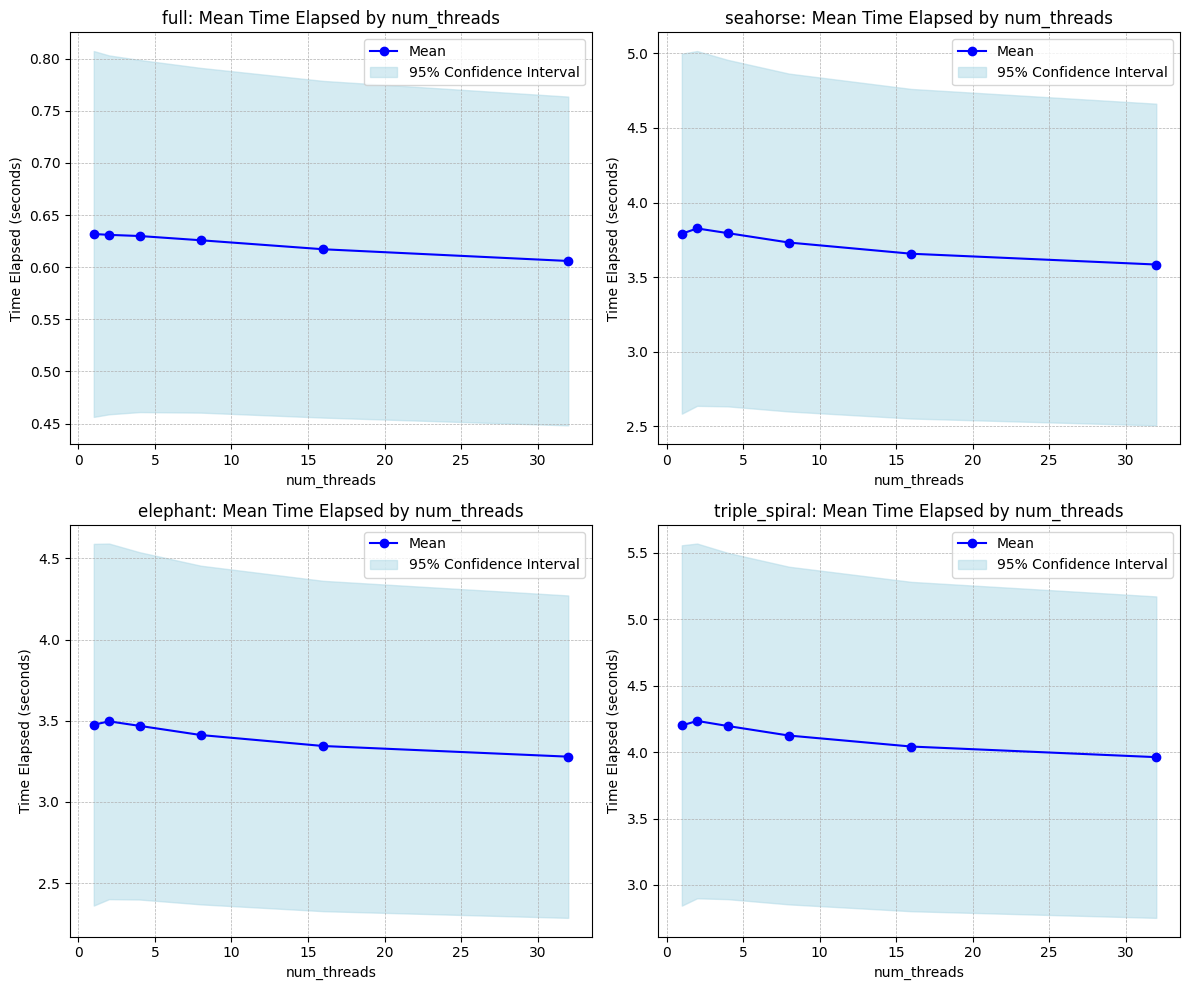

In [18]:
df_pth = df[df['name'] == 'mandelbrot_pth']
plot_mean_ci_by_region_num_threads(df_pth)

#### Tempo médio de execução por número de threads - OpenMP

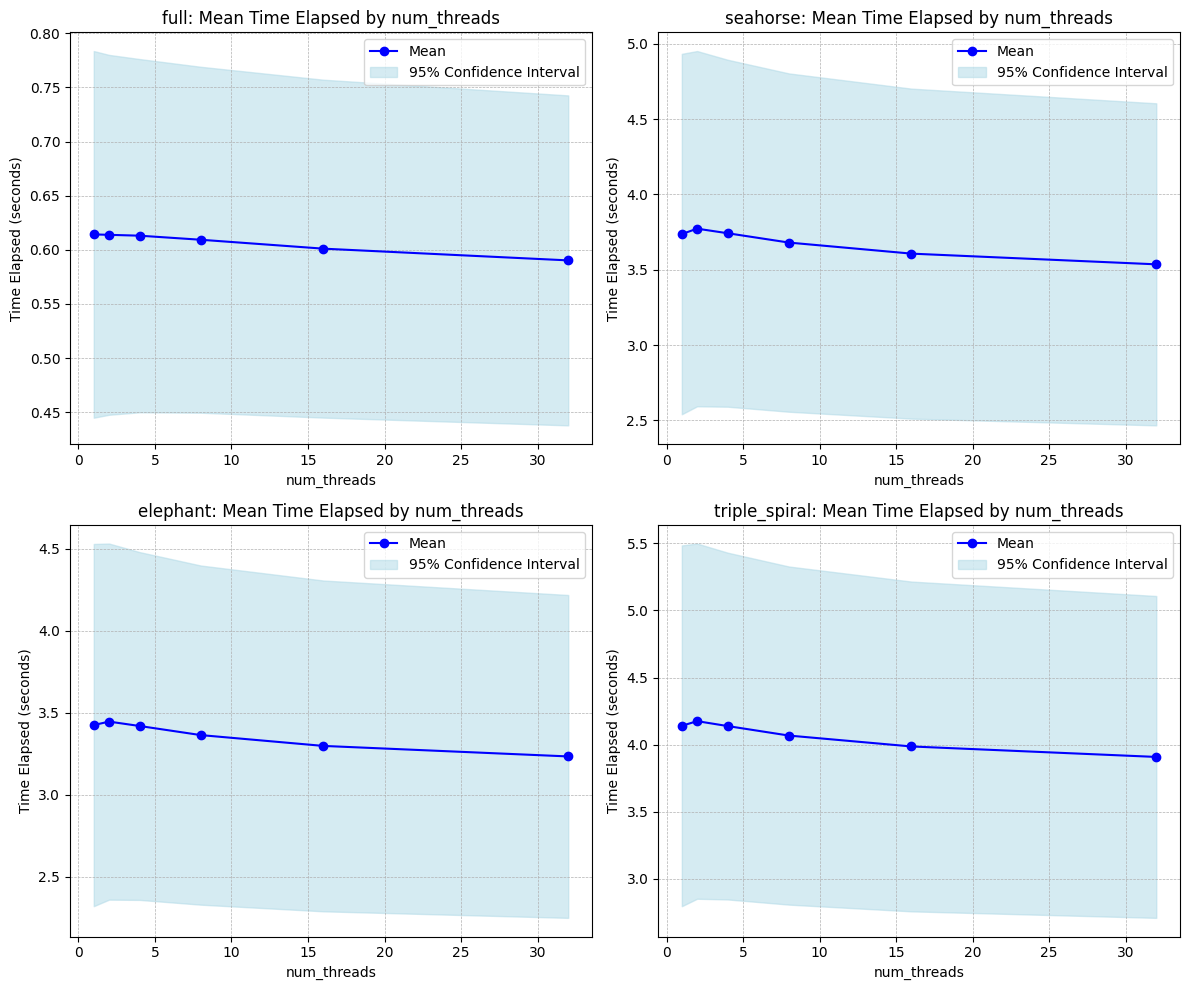

In [19]:
df_omp = df[df['name'] == 'mandelbrot_omp']
plot_mean_ci_by_region_num_threads(df_omp)

In [20]:
from utils.plots import plot_side_by_side_parallel

In [21]:
df = raw_data
df = df[df['IO'] == False]
df_seq = df[df['name'] == 'mandelbrot_seq']
df_parallel = df[df['name'] != 'mandelbrot_seq']

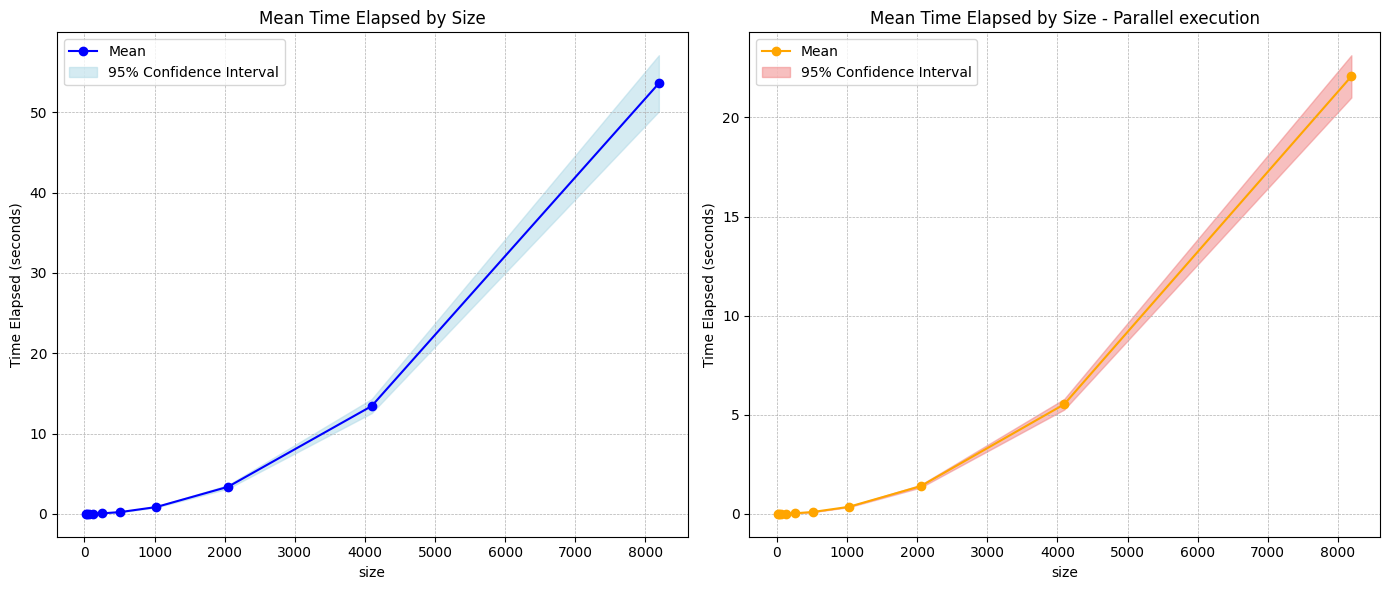

In [22]:
plot_side_by_side_parallel(df_seq, df_parallel, title="Mean Time Elapsed by Size")

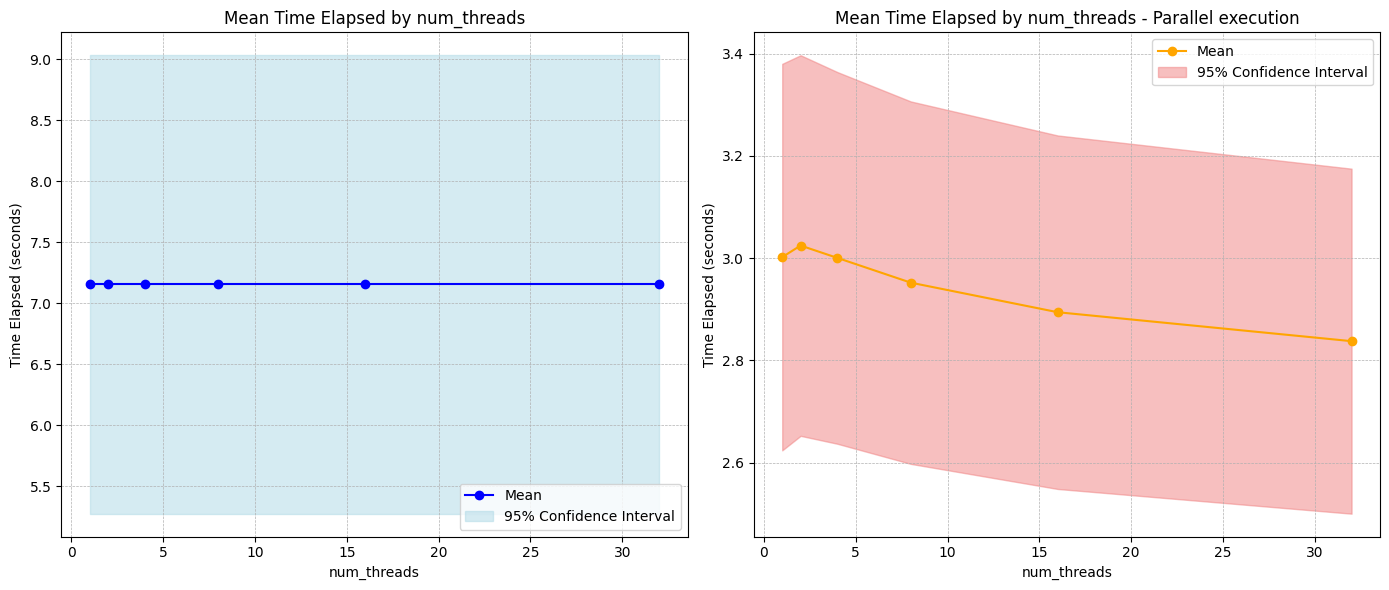

In [23]:
plot_side_by_side_parallel(df_seq, df_parallel, title="Mean Time Elapsed by num_threads", parameter="num_threads")

Observando os gráficos acima, constata-se que tempo de execução cresce de forma quadrática conforme o tamanho da entrada (`size`) aumenta e o tempo de execução médio reduz ligeiramente com o aumento do número de `threads` do código paralelizado, enquanto que o código sequencial não apresenta variação com a alteração do número de `threads`. Isto é esperado dado que a execução é sequencial. 

In [24]:
df_pth = df_parallel[df_parallel['name'] == 'mandelbrot_pth']
df_omp = df_parallel[df_parallel['name'] == 'mandelbrot_omp']

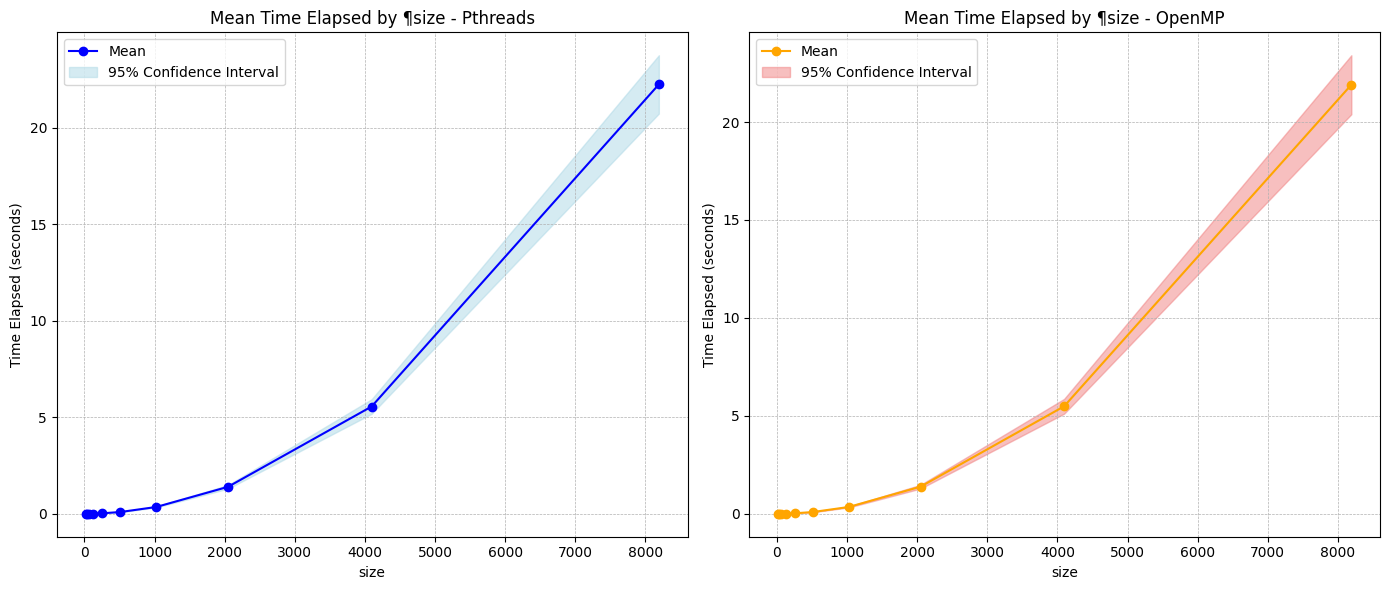

In [25]:
from utils.plots import plot_side_by_side_parallel_libs
plot_side_by_side_parallel_libs(df_pth, df_omp, title="Mean Time Elapsed by ¶size")

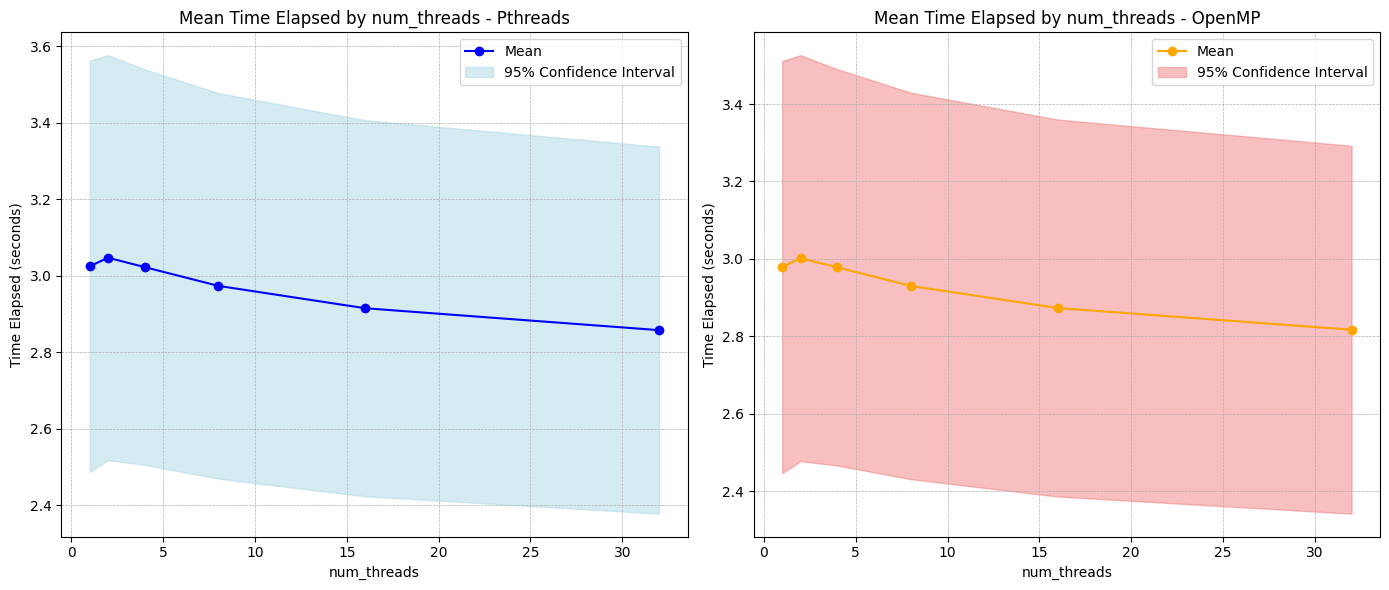

In [26]:
plot_side_by_side_parallel_libs(df_pth, df_omp, title="Mean Time Elapsed by num_threads", parameter="num_threads")

De forma geral, a otimização via `OpenMP` se mostrou mais eficiente que a implementação usando `pthreads`, tal diferença pode ser atribuída ao fato que o `OpenMP` é uma API de mais alto nível que permite a adição de paralelismo com poucas modificações no código, consequentemente, a chance da adição de erros na implementação do paralelismo é menor, se comparado com o `pthreads`. Além disso, o gerenciamento automático das threads pelo `OpenMP` se mostrou mais eficiente que o gerenciamento manual via `pthreads`.

## Considerações finais

A análise dos dados e gráficos apresentados neste relatório revelou informações importantes sobre o desempenho de diferentes abordagens de execução em relação ao uso de operações de I/O e à implementação de paralelismo. Observou-se que a geração de imagens do tipo `triple_spiral` resulta no maior tempo de execução médio na execução das 3 versões do código. Curiosamente, a remoção dessas operações levou a um aumento significativo no tempo médio de execução do código paralelizado, levantando questões sobre a eficácia do paralelismo implementado para esse cenário em específico.

As hipóteses levantadas, como overhead de contexto, concorrência excessiva, *deadlock*, falta de paralelismo eficiente, escalonamento ineficiente e desvio de cache, apontam para desafios comuns em ambientes *multithreaded* que podem impactar negativamente o desempenho. A relação entre o tempo de execução e o tamanho da entrada demonstra um crescimento quadrático, indicando que a complexidade do problema aumenta consideravelmente com a escalabilidade da entrada, mas que há ganhos significativos de tempo médio de execução com o código paralelo.

Em termos de otimização, o uso da API `OpenMP` demonstrou ser mais eficiente do que a implementação com `pthreads`. Essa diferença pode ser atribuída à natureza de alto nível do `OpenMP`, que facilita a introdução de paralelismo com menor risco de erros de implementação. Além disso, o gerenciamento automático de *threads* pelo `OpenMP` se provou mais eficaz do que a abordagem manual com `pthreads`. Em resumo, o exercício-programa ressalta a importância da escolha da ferramenta de paralelismo adequada e a consideração cuidadosa das operações envolvidas na execução, para alcançar um desempenho otimizado.